# CS4120 Final Project
### Junhao Lin, Xianrui She

### 1. Data Display & Preprocessing

In [5]:
# import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import re
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

In [6]:
# reading the data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [7]:
# data preprocessing
# data preview
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
# cut out the id columns and keep only texts and labels
train = train.iloc[:, -3:]

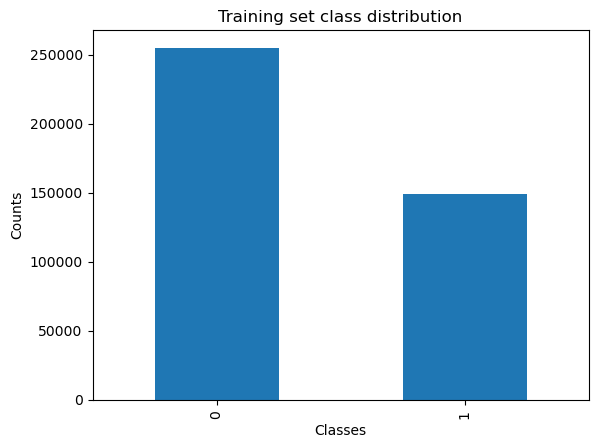

In [9]:
# class distribution
train['is_duplicate'].value_counts().plot.bar()
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Training set class distribution')
plt.show()

In [10]:
# cropping the training data so that classes are balanced (50/50)
min_length = len(train[train['is_duplicate']  == 1])
train_0 = train[train['is_duplicate']  == 0].sample(min_length, random_state=42)
# train_balanced = pd.concat([train_0, train[train['is_duplicate']  == 1]])
train_balanced = pd.concat([train_0[:min_length // 5], train[train['is_duplicate']  == 1][:min_length // 5]])

In [11]:
train_balanced.isna().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
train_balanced.dropna(axis=0)

,question1,question2,is_duplicate
362768,Do I legally have to let my employer know that...,Should I take a top-up home loan for doing up ...,0
172363,How do I jailbreak iOS 9.3.4?,How do I jailbreak iOS 9.2.1?,0
216382,Is my US income taxable if I am working on OPT...,I am working for company X. My client is Y (US...,0
303171,Why hasn't Ivanka Trump condemned the bigotry ...,How does it feel to date Ivanka Trump?,0
122527,Can a mortar shell be fired accurately without...,Why is my ex doing this?,0
...,...,...,...
80109,What are some mind-blowing technology tools th...,What are some mind-blowing tech tools that mos...,1
80110,Why do people love dogs so much?,Why do some people love dogs so much?,1
80112,How do we learn from mistakes?,What is the best way to learn from mistakes?,1
80114,Why MS Dhoni has quit the captaincy from limit...,Why did MS Dhoni quit ODI and T20 captaincy?,1


In [13]:
def normalize(text:str) -> list:
    ''' Function to tokenize our data correctly

    - input: text(str), unprocessed material
    - output: result(list), processed material
    '''
    # print(text)
    text = text.replace('%', ' percent ')
    text = text.replace('₹', ' rupee ')
    text = text.replace('€', ' euro ')
    text = text.replace('@', ' at ')
    text = text.replace('¥', ' yuan ')


    # convert all stemmed words to its original form
    stemmer = SnowballStemmer('english')
    #text = stemmer.stem(text)
    tokens = word_tokenize(text)

    for i in range(len(tokens)):
        tokens[i] = stemmer.stem(tokens[i])
    
    return ' '.join(tokens)

    

In [14]:
# test for normalize
str1 = "I exchanged 10$ to 70.9999¥"

normalize(str1)

'i exchang 10 $ to 70.9999 yuan'

In [15]:
# tokenize sentences in training data 
train_q1 = list(train_balanced['question1'].apply(normalize))
train_q2 = list(train_balanced['question2'].apply(normalize))

In [16]:
# vectorization
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
q1_vec = vectorizer.fit_transform(train_q1)
q2_vec = vectorizer.fit_transform(train_q2)

In [17]:
from scipy.sparse import hstack
X = hstack((q1_vec, q2_vec))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train,y_dev = train_test_split(X, train_balanced['is_duplicate'], test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model_1 = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-4, n_jobs=4, alpha=0.0002, early_stopping=True)
model_1.fit(X_train,y_train)
y_pred = model_1.predict(X_dev)
print('The accuracy for baseline logistic regression:', accuracy_score(y_dev,y_pred))

The accuracy for baseline logistic regression: 0.7040448873628674


In [20]:
from sklearn.model_selection import GridSearchCV

params = {'tol':[]}

In [21]:
y_pred_prob = model_1.predict_proba(X_dev)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
for i in thresholds:
    y_pred = [1 if y_hat_val[1] > i else 0 for y_hat_val in y_pred_prob]
    print(f'Accuracy for threshold = {i}:', accuracy_score(y_dev,y_pred))

Accuracy for threshold = 0.3: 0.6469307428188594
Accuracy for threshold = 0.4: 0.6861234402478854
Accuracy for threshold = 0.5: 0.7040448873628674
Accuracy for threshold = 0.6: 0.6885520475672054
Accuracy for threshold = 0.7: 0.6476007034586718


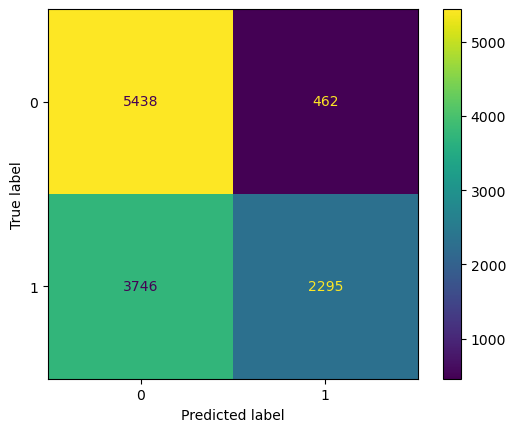

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_dev, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()